## Traditional ML classification models under wavelet analysis structures

In [1]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

### Implementations
#### Configurations

In [2]:
# Configurations - Feature names
LOWLUX = 'lowlux'
MIDLUX = 'middlelux'
HIGHLUX = 'highlux'
NOBACK = 'nothing'
ONEBACK = 'ONEBACK'
TWOBACK = 'TWOBACK'
THREEBACK = 'THREEBACK'
FILENAME = 'Filename'
IPA2 = 'IPA 2'
INDEX = 'index'
LUX = 'Luminance'
LABELS = 'Labels'
ISBLINK_LEFT = 'isBlink-Left'
ISBLINK_RIGHT = 'isBlink-Right'
PID = 'PID'
AVE_DM = 'Averaged Diameter'
DIFF_DM = 'Difference Diameter'

# Model names.
KNN = 'KNN'
SVM = 'SVM'
RF = 'Random Forest'

# Training and testing ratio.
TEST_SIZE_PCT = 0.1

# Hyper-parameters tuning.
# Setting thresholds for 2 eyes' blinking rates.
THRES_BLINKING_RATE = 0.3 # The default value.
# The random forest layers.
RF_DEPTH = 10

#### Read data

In [3]:
# Read data and make them into processable formalities.
filepath = '../Data/Results/21-11-13-13/results.csv'
df_raw_features = pd.read_csv(filepath)

In [4]:
df_raw_features

,Left-0,Left-1,Left-2,Left-3,Left-4,Left-5,Left-6,Left-7,Left-8,Left-9,...,Right-147,Right-148,Right-149,Averaged Diameter,Difference Diameter,isBlink-Left,isBlink-Right,Luminance,PID,Labels
0,90.878101,90.000122,89.429937,90.488841,90.425234,90.336186,90.534690,90.501258,90.304912,90.299277,...,94.824154,95.681502,95.550234,46.214449,-2.993481,0.325000,0.370000,lowlux,7,nothing
1,90.272990,90.943095,90.475785,90.534682,90.372235,90.283447,90.175733,90.071457,89.966849,89.862239,...,94.965808,95.486500,94.833888,46.102734,-2.943094,0.168333,0.203333,lowlux,7,nothing
2,89.356322,88.406687,88.938648,89.101954,88.632723,89.213376,88.886822,88.681709,89.061931,88.684184,...,96.326834,96.544795,95.752655,46.330987,-3.043528,0.000000,0.000000,lowlux,7,nothing
3,89.591427,90.381350,89.822829,90.178344,90.201855,90.039328,89.327095,90.271126,89.445756,89.488081,...,94.325592,93.692027,93.015056,46.389218,-2.974158,0.135000,0.195000,lowlux,7,nothing
4,89.352206,89.354459,90.085756,90.154200,90.493916,88.939724,89.547730,90.279304,90.332414,91.536459,...,93.245723,93.272628,94.553329,45.993263,-2.558402,0.135000,0.195000,lowlux,7,nothing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2807,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,91.581850,91.573155,91.780403,46.211527,0.826298,1.000000,0.431667,lowlux,2,THREEBACK
2808,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,91.303723,91.315547,91.318091,46.219696,0.809960,1.000000,0.530000,lowlux,2,THREEBACK
2809,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,91.241145,91.231029,91.214267,46.202013,0.845325,1.000000,0.663333,lowlux,2,THREEBACK
2810,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,89.802735,90.034177,89.511720,46.105213,1.038926,1.000000,0.816667,lowlux,2,THREEBACK


#### Encoder

This part encodes features into numeric values.

In [5]:
# Encoding and Labeling
luxes = []
nbacks = []
df_numeric_features = df_raw_features.copy()

for index, row in df_numeric_features.iterrows():
    # Label luxes
    if LOWLUX in row[LUX]:
        luxes.append(30)
    elif MIDLUX in row[LUX]:
        luxes.append(4500)
    elif HIGHLUX in row[LUX]:
        luxes.append(15000)
    
    # Label task difficulties
    if NOBACK in row[LABELS]:
        nbacks.append(0)
    elif ONEBACK in row[LABELS]:
        nbacks.append(1)
    elif TWOBACK in row[LABELS]:
        nbacks.append(2)
    elif THREEBACK in row[LABELS]:
        nbacks.append(3)
        
df_numeric_features[LUX] = luxes
df_numeric_features[LABELS] = nbacks

In [6]:
df_numeric_features

,Left-0,Left-1,Left-2,Left-3,Left-4,Left-5,Left-6,Left-7,Left-8,Left-9,...,Right-147,Right-148,Right-149,Averaged Diameter,Difference Diameter,isBlink-Left,isBlink-Right,Luminance,PID,Labels
0,90.878101,90.000122,89.429937,90.488841,90.425234,90.336186,90.534690,90.501258,90.304912,90.299277,...,94.824154,95.681502,95.550234,46.214449,-2.993481,0.325000,0.370000,30,7,0
1,90.272990,90.943095,90.475785,90.534682,90.372235,90.283447,90.175733,90.071457,89.966849,89.862239,...,94.965808,95.486500,94.833888,46.102734,-2.943094,0.168333,0.203333,30,7,0
2,89.356322,88.406687,88.938648,89.101954,88.632723,89.213376,88.886822,88.681709,89.061931,88.684184,...,96.326834,96.544795,95.752655,46.330987,-3.043528,0.000000,0.000000,30,7,0
3,89.591427,90.381350,89.822829,90.178344,90.201855,90.039328,89.327095,90.271126,89.445756,89.488081,...,94.325592,93.692027,93.015056,46.389218,-2.974158,0.135000,0.195000,30,7,0
4,89.352206,89.354459,90.085756,90.154200,90.493916,88.939724,89.547730,90.279304,90.332414,91.536459,...,93.245723,93.272628,94.553329,45.993263,-2.558402,0.135000,0.195000,30,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2807,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,91.581850,91.573155,91.780403,46.211527,0.826298,1.000000,0.431667,30,2,3
2808,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,91.303723,91.315547,91.318091,46.219696,0.809960,1.000000,0.530000,30,2,3
2809,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,91.241145,91.231029,91.214267,46.202013,0.845325,1.000000,0.663333,30,2,3
2810,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,89.802735,90.034177,89.511720,46.105213,1.038926,1.000000,0.816667,30,2,3


#### Data visualization

In [7]:
# sns.pairplot(df_labels_IPA2, hue=LABELS)

#### Auxiliary functions

In [8]:
# Show machine learning models' performance.
def show_performance(y_true, y_pred):
    # Get the accuracy score.
    score = accuracy_score(y_true, y_pred)
    
    # Get the confusion matrices and display them.
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(cm)
    
    ax = plt.figure().subplots()
    ax.set(title="MODEL")
    
    cm_display.plot(ax=ax)
    plt.show()
    
    return score

In [9]:
# Plot class distributions with a bar chart.
# Learnt from the quora here.https://stackoverflow.com/questions/63650646/add-labels-and-title-to-a-plot-made-using-pandas.
def plot_class_distribution(df_input, title, x_label, y_label, class_column):
    df = df_input.copy()
    ax = pd.Series(df[class_column]).value_counts().sort_index().plot(kind='bar')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
#     ax.set_title(title)
#     ax.set_xlabel(x_label)
#     ax.set_ylabel(y_label)
    return None


#### Implementing with a encapsulated function.

In [10]:
def ml_pipeline(df_input):
    df = df_input.copy()
    # Feature selection
    # Remove PID label / feature.
    df = df.loc[:, df.columns != PID]
    
    # Remove lux
    df = df.loc[:, df.columns != LUX]
    
    # Remove blinks.
    before_blinking_filter = len(df)
    df = df.loc[df[ISBLINK_LEFT] <= THRES_BLINKING_RATE]
    df = df.loc[df[ISBLINK_RIGHT] <= THRES_BLINKING_RATE]
    after_blinking_filter = len(df)
    lost_data_num = before_blinking_filter - after_blinking_filter
    print('The blinking threshold is: ' + str(THRES_BLINKING_RATE) + '. Before there was: ' + str(before_blinking_filter) + ' instances, then there is : ' + str(after_blinking_filter) + ' instances. ' + str(lost_data_num) + ' instances are lost.')
#     df = df.reset_index()  # This will add a feature column index to the dataset, and increases accuracy largely for KNN model. Comment this line. While SVM was less affected by KNN. 
    df_output = df.copy()
    plot_class_distribution(df_input=df_output, title='Tuned instances - class distribution', x_label='Classes', y_label='Instances', class_column=LABELS) # Show the class distributions after tuning.
    
    # Remove the blinking rates related features.
    df = df.loc[:, df.columns != ISBLINK_LEFT]
    df = df.loc[:, df.columns != ISBLINK_RIGHT]
    
    
    # Split dataset.
    # Get the X and y sets.
    X = df.loc[:, df.columns != LABELS].to_numpy()
    y = df.loc[:, df.columns == LABELS].to_numpy()
    y = np.reshape(y, -1)
    
    # Split the data into training dataset and validation dataset.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_PCT, random_state=999)
    
    # Train with models.
    # SVM model. TODO: try the SVM model mentioned in 2022 ISMAR and boosting method, and also feature selection method.
    clf_svm = make_pipeline(StandardScaler(),SVC(kernel='poly', degree=7)) #SVC(kernel='rbf', gamma='auto'))
    # Try SVM, bacause it is one of the most widely used models in cognitive workload claissfications.
    clf_svm.fit(X_train, y_train)
    y_pred_svm = clf_svm.predict(X_test)
    score_svm = show_performance(y_true=y_test, y_pred=y_pred_svm)
    
    # KNN model.
    clf_knn = KNeighborsClassifier(n_neighbors=5)
    # Train the model.
    clf_knn.fit(X_train, y_train)
    # Test.
    y_pred_knn = clf_knn.predict(X_test)
    score_knn = show_performance(y_true=y_test, y_pred=y_pred_knn)
    
    # Random Forest model.
    clf_rf = RandomForestClassifier(max_depth=RF_DEPTH, random_state=0)
    # Train the model.
    clf_rf.fit(X_train, y_train)
    # Test.
    y_pred_rf = clf_rf.predict(X_test)
    score_rf = show_performance(y_true=y_test, y_pred=y_pred_rf)
    
    # Print the results.
    print('The SVM result is: ' + str(score_svm) +  '\nThe KNN result is: ' + str(score_knn) +  '\nThe RF result is: ' + str(score_rf))
    
    return df_output

#### Machine Learning Implementations

CPU times: total: 0 ns
Wall time: 0 ns
------------------------------------------------Time-domain-based Features Model ------------------------------------------------
The blinking threshold is: 0.3. Before there was: 2812 instances, then there is : 1300 instances. 1512 instances are lost.


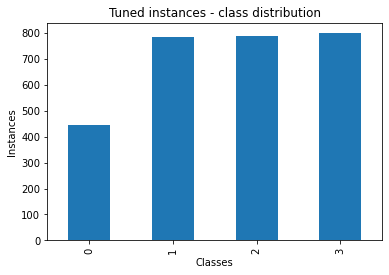

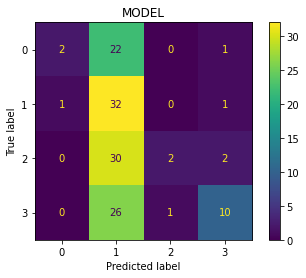

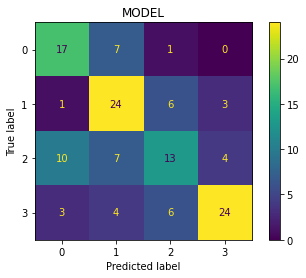

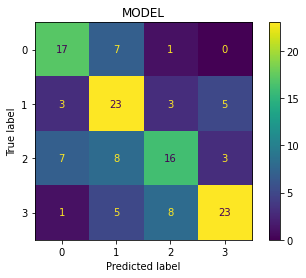

The SVM result is: 0.35384615384615387
The KNN result is: 0.6
The RF result is: 0.6076923076923076
------------------------------------------------My Proposed Features Model ------------------------------------------------
The blinking threshold is: 0.3. Before there was: 2812 instances, then there is : 1300 instances. 1512 instances are lost.


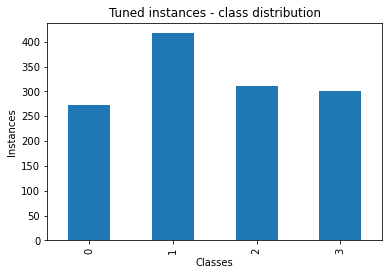

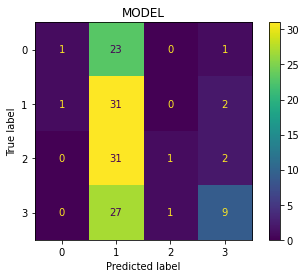

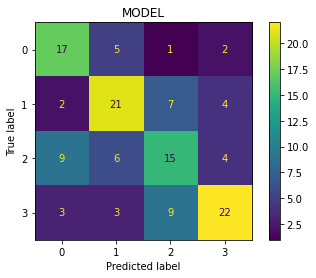

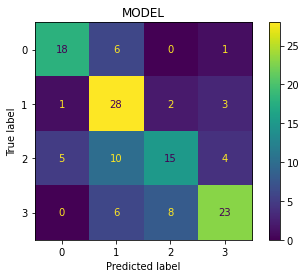

The SVM result is: 0.3230769230769231
The KNN result is: 0.5769230769230769
The RF result is: 0.6461538461538462


In [11]:
%time
# Test: time-domain feature sets.
time_domain_features = [AVE_DM, DIFF_DM, ISBLINK_LEFT, ISBLINK_RIGHT, LUX, PID, LABELS]
df_baseline_time_features = df_numeric_features[time_domain_features].copy()

# The proposed features.
df_proposed = df_numeric_features.copy()

def feature_pipeline(df_input, label_string): # This pipeline runs different feature sets - will be replaced by the feature-selection.
    print('------------------------------------------------' + label_string + ' Model ------------------------------------------------')
    df_used_features = ml_pipeline(df_input=df_input)
#     print('The used features are: ') # Briefly display the features utilized.
#     print(df_used_features)  
#     plot_class_distribution(df_input=df_used_features, title='Tuned instances - class distribution', x_label='Classes', y_label='Instances', class_column=LABELS) # Show the class distributions after tuning.

# Looping and fine-tuning hyper-parameters. <TODO>


# Compare different features.
plot_class_distribution(df_input=df_proposed, title='Original instances - class distribution', x_label='Classes', y_label='Instances', class_column=LABELS) # class distributions before.
# Time-domain based features alone.
feature_pipeline(df_input=df_baseline_time_features, label_string='Time-domain-based Features')
# My proposed feature based features.
feature_pipeline(df_input=df_proposed, label_string='My Proposed Features')

In [12]:
# Now the best parameter set:
# param = {train_test_size = 0.1, threshold_blinking_rate=0.7, SVM acc=0.4333, knn_num_neighbor=5, knn acc=0.86699}